In [1]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4' 

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator


E0000 00:00:1743892685.658142  444364 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743892685.662271  444364 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743892685.674710  444364 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743892685.674738  444364 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743892685.674743  444364 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743892685.674745  444364 computation_placer.cc:177] computation placer already registered. Please check linka

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# GLOBAL VARIABLES
dataset = "animals"
base_dir = os.path.join("datasets", dataset)
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
augmented_dir = os.path.join(base_dir, "aug")
os.makedirs(augmented_dir, exist_ok=True)

models_dir = os.path.join("models", dataset)
os.makedirs(models_dir, exist_ok=True)

metadata_file = os.path.join(models_dir, "metadata.csv")
metrics_file = os.path.join(models_dir, "metrics.csv")

# HYPERPARAMETERS
HYPERPARAMETERS = {
    "model_version": 6,
    # Image processing
    "img_width": 64,
    "img_height": 64,
    "rescale": 1.0 / 255,
    "rotation_range": 10,
    "width_shift_range": 0.2,
    "zoom_range": 0.3,
    "horizontal_flip": True,
    # Training
    "batch_size": 16,
    # Model
    "num_classes": 90,
    "learning_rate": 0.00001,
    # "conv_layers": 10,
    # "conv_shape": (3, 3), 
    # "pool_shape": (2, 2),
    # "internal_neurons": 256
}

epochs = 10

In [4]:
import hashlib

# USING THE HYPERPARAMETERS GENERATE A KEY (HASH)
def generate_hash():
    hash_input = ""
    for key, value in HYPERPARAMETERS.items():
        if isinstance(value, list):
            value = str(value)
        hash_input += f"{key}:{value};"
    # Generate a hash
    return hashlib.md5(hash_input.encode()).hexdigest()

In [5]:
hash_key = generate_hash()

if not os.path.exists(metadata_file):
    cols = ["hash_key"]
metadata = pd.read_csv(metadata_file)
if hash_key not in metadata["hash_key"].values:
    metadata = pd.read_csv(metadata_file)
    new_row = {**HYPERPARAMETERS, "hash_key": hash_key}
    metadata = pd.concat([metadata, pd.DataFrame([new_row])], ignore_index=True)
    metadata.to_csv(metadata_file, index=False)

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=10,
    width_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=HYPERPARAMETERS["horizontal_flip"],
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(HYPERPARAMETERS["img_width"], HYPERPARAMETERS["img_height"]),
    batch_size=HYPERPARAMETERS["batch_size"],
    class_mode="binary",
    save_to_dir=augmented_dir,
    save_prefix="aug",
    save_format="png",
)

Found 4320 images belonging to 90 classes.


In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(
    layers.Input(
        shape=(HYPERPARAMETERS["img_width"], HYPERPARAMETERS["img_height"], 3),
    )
)

model.add(
    layers.Conv2D(64, kernel_size=3, activation="relu", padding="same", strides=2)
)
model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(
    layers.Conv2D(128, kernel_size=3, activation="relu", padding="same", strides=2)
)
model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(layers.Conv2D(256, kernel_size=3, activation="relu", padding="same"))
model.add(layers.Conv2D(256, kernel_size=3, activation="relu", padding="same", strides=2))
model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(layers.Conv2D(512, kernel_size=3, activation="relu", padding="same"))
model.add(layers.Conv2D(512, kernel_size=3, activation="relu", padding="same", strides=2))
model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(layers.Conv2D(512, kernel_size=3, activation="relu", padding="same"))
model.add(layers.Conv2D(512, kernel_size=3, activation="relu", padding="same", strides=2))
model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(4096, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(4096, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(HYPERPARAMETERS["num_classes"], activation="softmax"))

model.summary()

I0000 00:00:1743892687.907979  444364 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4168 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 90)             │       368,730 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,763,226 (132.61 MB)

 Trainable params: 34,763,226 (132.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=HYPERPARAMETERS["learning_rate"]),
    metrics=["acc"],
)

In [9]:
histories = []

In [35]:
# Reduce LR on plateu
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.5,
    patience=2,
    min_lr=1e-8,
    verbose=1,
)


In [36]:
start = 120
for i in range(8):
    print(f"Training {i+1}...")
    curr_epochs = str((i + 1) * epochs + start)
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        verbose=1,
        callbacks=[reduce_lr],
    )
    histories.append(history)

    model_path = os.path.join(models_dir, hash_key, curr_epochs)
    os.makedirs(model_path, exist_ok=True)

    model.save(os.path.join(model_path, f"model_{hash_key}_epochs_{curr_epochs}.h5"))
    # Save metrics
    metrics = pd.DataFrame(history.history)
    metrics["epoch"] = curr_epochs
    metrics["hash_key"] = hash_key
    metrics.to_json(
        model_path + f"/metrics_{hash_key}_epochs_{curr_epochs}.json",
        orient="records",
        lines=True,
        index=False,
    )

Training 1...
Epoch 1/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - acc: 0.8795 - loss: 0.4199 - learning_rate: 1.0000e-05
Epoch 2/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - acc: 0.8634 - loss: 0.4711 - learning_rate: 1.0000e-05
Epoch 3/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - acc: 0.8737 - loss: 0.4153
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
270/270 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - acc: 0.8736 - loss: 0.4154 - learning_rate: 1.0000e-05
Epoch 4/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - acc: 0.8979 - loss: 0.3794 - learning_rate: 5.0000e-06
Epoch 5/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - acc: 0.9290 - loss: 0.2534 - learning_rate: 5.0000e-06
Epoch 6/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - acc: 0.9313 - loss: 0.2485 - learning_rate: 5.0000e-06
Epoch 7/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - acc: 0.9278 - loss: 0.2526
Epoch 7: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
270/270 ━━━━━━━

Training 2...
Epoch 1/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - acc: 0.9523 - loss: 0.1815 - learning_rate: 2.5000e-06
Epoch 2/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - acc: 0.9496 - loss: 0.1734 - learning_rate: 2.5000e-06
Epoch 3/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - acc: 0.9500 - loss: 0.1837 - learning_rate: 2.5000e-06
Epoch 4/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - acc: 0.9489 - loss: 0.1714 - learning_rate: 2.5000e-06
Epoch 5/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - acc: 0.9486 - loss: 0.1793 - learning_rate: 2.5000e-06
Epoch 6/10
269/270 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - acc: 0.9494 - loss: 0.1792
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.
270/270 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - acc: 0.9494 - loss: 0.1792 - learning_rate: 2.5000e-06
Epoch 7/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - acc: 0.9596 - loss: 0.1528 - learning_rate: 1.2500e-06
Epoch 8/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - acc: 0

Training 3...
Epoch 1/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - acc: 0.9638 - loss: 0.1335 - learning_rate: 1.2500e-06
Epoch 2/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - acc: 0.9655 - loss: 0.1381 - learning_rate: 1.2500e-06
Epoch 3/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - acc: 0.9535 - loss: 0.1508
Epoch 3: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.
270/270 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - acc: 0.9535 - loss: 0.1508 - learning_rate: 1.2500e-06
Epoch 4/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - acc: 0.9673 - loss: 0.1178 - learning_rate: 6.2500e-07
Epoch 5/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - acc: 0.9676 - loss: 0.1177 - learning_rate: 6.2500e-07
Epoch 6/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - acc: 0.9667 - loss: 0.1184 - learning_rate: 6.2500e-07
Epoch 7/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - acc: 0.9735 - loss: 0.0959 - learning_rate: 6.2500e-07
Epoch 8/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - acc: 0.

Training 4...
Epoch 1/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - acc: 0.9687 - loss: 0.1062 - learning_rate: 3.1250e-07
Epoch 2/10
180/270 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - acc: 0.9653 - loss: 0.1064

KeyboardInterrupt: 

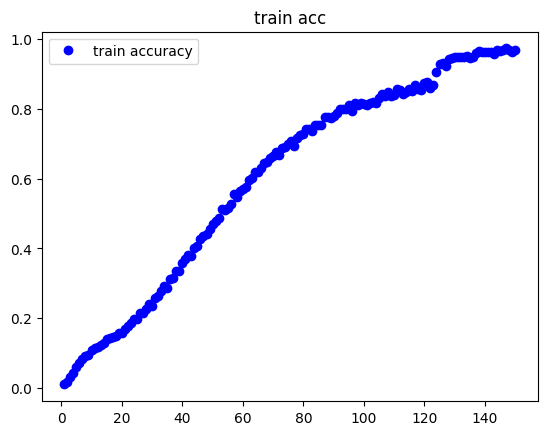

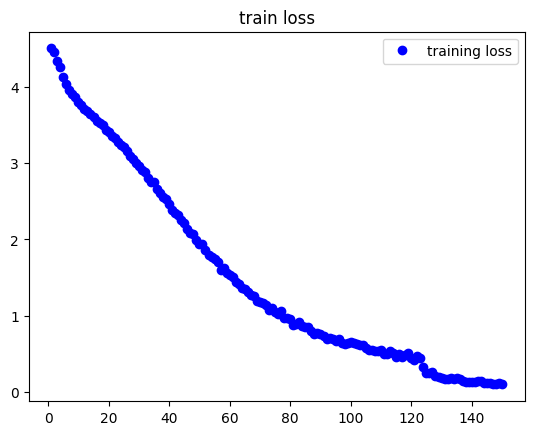

In [37]:
acc = histories[0].history['acc']
for i in range(1, len(histories)):
    acc = np.concatenate((acc, histories[i].history['acc']))

loss = histories[0].history['loss']
for i in range(1, len(histories)):
    loss = np.concatenate((loss, histories[i].history['loss']))
# Save the model

epochs_range = range(1, len(acc) + 1)

plt.plot(epochs_range, acc, "bo", label="train accuracy")
plt.title("train acc")
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, "bo", label="training loss")
plt.title("train loss")
plt.legend()

plt.show()

In [39]:
test_datagen = ImageDataGenerator(1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(HYPERPARAMETERS["img_width"], HYPERPARAMETERS["img_height"]),
    batch_size=20,
    class_mode="binary",
)

test_loss, test_acc = model.evaluate(test_generator)
print("\ntest acc :\n", test_acc)

Found 1080 images belonging to 90 classes.
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - acc: 0.3472 - loss: 1596.8114

test acc :
 0.34351852536201477
